## Mount google drive

In [1]:
from google.colab import drive
drive.mount._DEBUG = False
drive.mount('/content/gdrive/')
%ls /content/gdrive/'My Drive'/Deeplearning/Lab_ML_Projects/Ions_in_confinement/collectDatawhole.dat

Mounted at /content/gdrive/
'/content/gdrive/My Drive/Deeplearning/Lab_ML_Projects/Ions_in_confinement/collectDatawhole.dat'


## Load modules

In [2]:
#Lib imports
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('default')
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split as spliter
from sklearn import preprocessing
import joblib
tf.__version__

'2.4.1'

## Read the dataset

In [3]:
file_path = "/content/gdrive/My Drive/Deeplearning/Lab_ML_Projects/Ions_in_confinement/"
df = pd.read_csv(file_path+'collectDatawhole.dat', delimiter = ",")

## Details about dataset

In [4]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3432 entries, 0 to 3431
Columns: 455 entries, #Z_val to stringErrorBar149
dtypes: float64(453), int64(2)
memory usage: 11.9 MB
None


In [5]:
input_params = df.loc[:, '#Z_val':'d_val']
z_values = df.loc[:, 'stringPosition0':'stringPosition148']
density_values = df.loc[:, 'stringDensity0' : 'stringDensity148']
errorbar_values = df.loc[:, 'stringErrorBar0' : 'stringErrorBar148']

#print(input_params.shape)
print(input_params)
#print(z_values.shape)
print(z_values)
#print(density_values.shape)
print(density_values)
#print(errorbar_values.shape)
print(errorbar_values)

      #Z_val  p_val  n_val   c_val  d_val
0        3.0      1      -1    0.3  0.500
1        3.0      1      -1    0.3  0.550
2        3.0      1      -1    0.3  0.553
3        3.0      1      -1    0.3  0.600
4        3.0      1      -1    0.3  0.650
...      ...    ...     ...    ...    ...
3427     4.0      3      -1    0.9  0.600
3428     4.0      3      -1    0.9  0.650
3429     4.0      3      -1    0.9  0.700
3430     4.0      3      -1    0.9  0.714
3431     4.0      3      -1    0.9  0.750

[3432 rows x 5 columns]
      stringPosition0  stringPosition1  ...  stringPosition147  stringPosition148
0            -1.49500         -1.48500  ...           -0.03500           -0.02500
1            -1.49450         -1.48350  ...            0.11150            0.12250
2            -1.49447         -1.48341  ...            0.12029            0.13135
3            -1.49400         -1.48200  ...            0.25800            0.27000
4            -1.49350         -1.48050  ...            0.4045

## Supporting functions

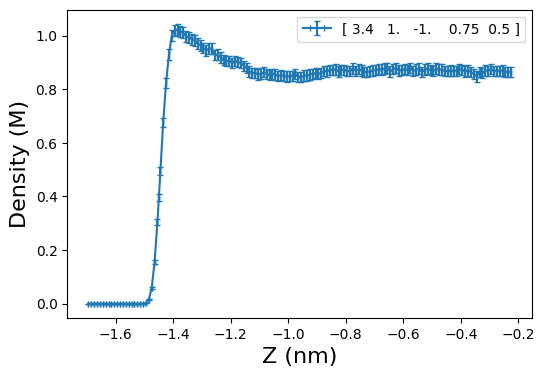

In [12]:
def plot_density_profile(z_values, density, error_bars=None, label=None):

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
    if error_bars is None:
        ax.plot(z_values, density, label=label)
    else:
        ax.errorbar(z_values, density, xerr=0.0, yerr=error_bars, capsize=2, label=label)
        

    ax.axis('tight')
    ax.xaxis.set_tick_params(labelsize='medium')
    ax.yaxis.set_tick_params(labelsize='medium')
    ax.set_xlabel('Z (nm)', fontsize=16)
    ax.set_ylabel('Density (M)', fontsize=16)
    ax.legend()

selected_index = np.random.randint(z_values.values.shape[0], size=1)[0]

plot_density_profile(z_values.values[selected_index], density_values.values[selected_index], errorbar_values.values[selected_index], label=input_params.values[selected_index])

## Select data for model training

In [13]:
train_test_split = 0.8

input_data = input_params.values
output = density_values.values
errors = errorbar_values.values
z_data = z_values.values
print("Input data shape: {}".format(input_data.shape))
print("Output data shape: {}".format(output.shape))

input_data_suff, output_suff,  errors_suff, z_data_shuff = shuffle(input_data, output, errors, z_data)

train_test_split_ = int(input_data_suff.shape[0]*train_test_split)

x_train = input_data_suff[0:train_test_split_]
x_test = input_data_suff[train_test_split_:]
y_train = output_suff[0:train_test_split_]
y_test = output_suff[train_test_split_:]

error_train = errors_suff[0:train_test_split_]
error_test = errors_suff[train_test_split_:]
z_data_train = z_data_shuff[0:train_test_split_]
z_data_test = z_data_shuff[train_test_split_:]
#x_train, x_test, y_train, y_test = spliter.train_test_split(input_data, output, test_size=(1-train_test_split), random_state=100)

print("Train input: ", x_train.shape)
print("Train Output", y_train.shape)
print("Test input: ", x_test.shape)
print("Test Output", y_test.shape)

Input data shape: (3432, 5)
Output data shape: (3432, 149)
Train input:  (2745, 5)
Train Output (2745, 149)
Test input:  (687, 5)
Test Output (687, 149)


## Input feature scaling

In [14]:
#scaler = preprocessing.MinMaxScaler() # s the probably the most famous scaling algorithm, and follows the following formula for each feature:
#scaler = preprocessing.StandardScaler() # assumes your data is normally distributed within each feature
#scaler = preprocessing.RobustScaler() # interquartile range, so if there are outliers in the data, you might want to consider the Robust Scaler
#scaler = preprocessing.Normalizer() # The normalizer scales each value by dividing each value by its magnitude in n-dimensional space for n number of features.
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
scaled_x_train = scaler.fit_transform(x_train)
#arr_transformed = sc.fit_transform(arr_selected)
scaled_x_test = scaler.transform(x_test)
# Save the scaler for future use
joblib.dump(scaler, file_path+'scaler_new.pkl')

['/content/gdrive/My Drive/Deeplearning/Lab_ML_Projects/Ions_in_confinement/scaler_new.pkl']

## Model parameters

In [16]:
# hyper parameters
learningRate = 0.0001
beta_1 = 0.9
beta_2 = 0.999
decay = 0.000000

batchSize = 32
dropout_rate=0.15
epochs= 500

# Network Parameters
inputFeatures = 5 
hiddenUnits1 = 512 # 1st layer number of neurons
hiddenUnits2 = 256 # 2nd layer number of neurons
outputClasses = 149

## ANN Model

In [17]:
#This is He initializer
initializer = tf.keras.initializers.VarianceScaling(scale=2.0, mode='fan_in', distribution='truncated_normal', seed=None)

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(hiddenUnits1, activation=tf.nn.relu, kernel_initializer=initializer, input_shape=(inputFeatures, )))
model.add(tf.keras.layers.Dropout(rate=dropout_rate))
model.add(tf.keras.layers.Dense(hiddenUnits2, activation=tf.nn.sigmoid , kernel_initializer=initializer))
model.add(tf.keras.layers.Dropout(rate=dropout_rate))
model.add(tf.keras.layers.Dense(outputClasses,  kernel_initializer=initializer))


model.compile(loss=tf.keras.losses.mean_squared_error, optimizer=tf.keras.optimizers.Adam(lr=learningRate, beta_1=beta_1,beta_2=beta_2, decay=decay))

#history = model.fit(x_train, y_train, epochs=epochs, batch_size = batchSize, verbose = 1, validation_data = (x_test, y_test), shuffle=True)

## Training

In [18]:
history = model.fit(scaled_x_train, y_train, epochs=epochs, batch_size = batchSize, verbose = 1, validation_data = (scaled_x_test, y_test), shuffle=True)

Epoch 1/500
86/86 [==============================] - 2s 4ms/step - loss: 0.5933 - val_loss: 0.0889
Epoch 2/500
86/86 [==============================] - 0s 2ms/step - loss: 0.1384 - val_loss: 0.0448
Epoch 3/500
86/86 [==============================] - 0s 3ms/step - loss: 0.0918 - val_loss: 0.0284
Epoch 4/500
86/86 [==============================] - 0s 2ms/step - loss: 0.0662 - val_loss: 0.0192
Epoch 5/500
86/86 [==============================] - 0s 2ms/step - loss: 0.0499 - val_loss: 0.0146
Epoch 6/500
86/86 [==============================] - 0s 2ms/step - loss: 0.0388 - val_loss: 0.0116
Epoch 7/500
86/86 [==============================] - 0s 2ms/step - loss: 0.0338 - val_loss: 0.0099
Epoch 8/500
86/86 [==============================] - 0s 3ms/step - loss: 0.0299 - val_loss: 0.0087
Epoch 9/500
86/86 [==============================] - 0s 2ms/step - loss: 0.0269 - val_loss: 0.0081
Epoch 10/500
86/86 [==============================] - 0s 2ms/step - loss: 0.0251 - val_loss: 0.0076
Epoch 11/

## Training and testing error

dict_keys(['loss', 'val_loss'])


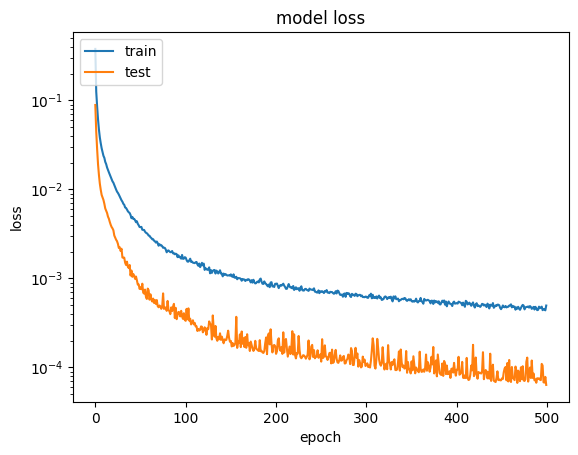

In [19]:
print(history.history.keys())
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.yscale('log')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

dict_keys(['loss', 'val_loss'])


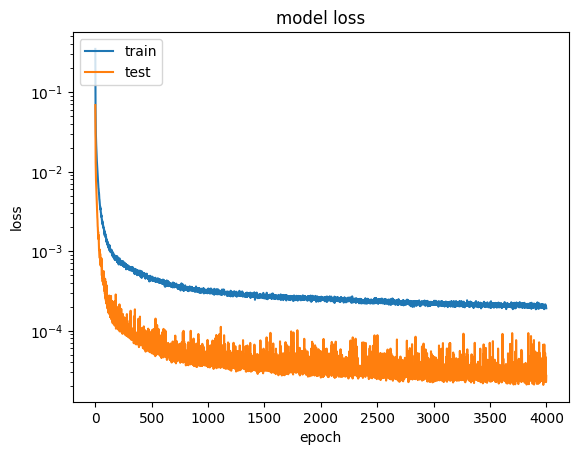

In [ ]:
print(history.history.keys())
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.yscale('log')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Model details and save the model

In [20]:
model.summary()
model.save(file_path+ 'my_model_new.h5')

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               3072      
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 149)               38293     
Total params: 172,693
Trainable params: 172,693
Non-trainable params: 0
_________________________________________________________________


## Load the models and predict

In [21]:
scaler = joblib.load(file_path+'scaler.pkl')
#scaler = joblib.load(file_path+'scaler_new.pkl')
new_model = tf.keras.models.load_model(file_path+'my_model.h5', compile=False)
#new_model = tf.keras.models.load_model(file_path+ 'my_model_new.h5')

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.preprocessing.data module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.preprocessing. Anything that cannot be imported from sklearn.preprocessing is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator MinMaxScaler from version 0.19.1 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


# Evaluating testing accuracy within error bars

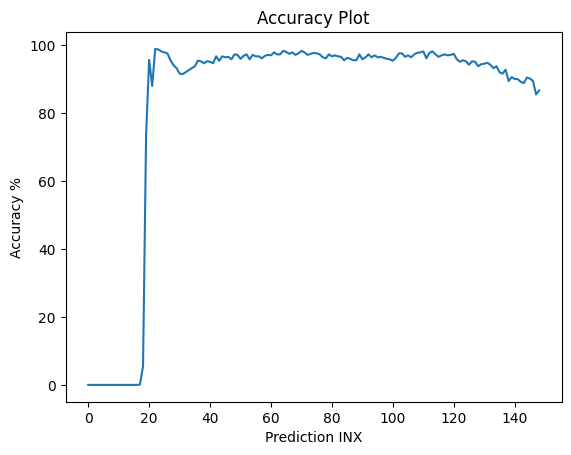

In [22]:
def evaluate(prediction, truth , errorbar):
  accuracy = []
  for i in range(prediction.shape[1]):
    cnt = 0;
    for j in range(prediction.shape[0]):
      if (abs(prediction[j,i] - truth[j,i]) <= errorbar[j,i]):
        cnt = cnt+1;
    accuracy.append(cnt/prediction.shape[0]);
  
  return np.array(accuracy)


predictions = new_model.predict(scaler.transform(x_test))
acc = evaluate(predictions, y_test, error_test)

plt.plot(acc*100.0)
plt.title('Accuracy Plot')
plt.ylabel('Accuracy %')
plt.xlabel('Prediction INX')
plt.show()


# Examples of prediction graphs

/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


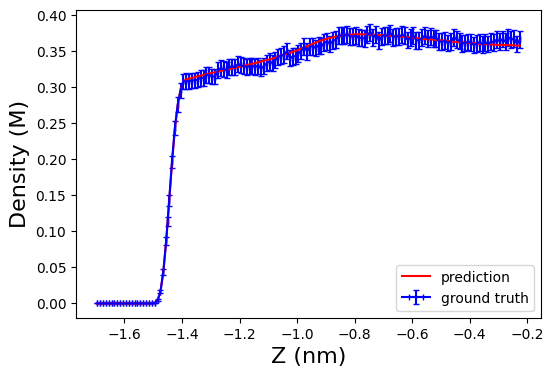

In [32]:
def plot_density_profile(ax, z_values, density, error_bars=None, label=None, title=None, color='b'):

    if error_bars is None:
        ax.plot(z_values, density, label=label, color=color)
    else:
        ax.errorbar(z_values, density, xerr=0.0, yerr=error_bars, capsize=2, label=label, color=color)
        
    ax.set_title(title)
    ax.axis('tight')
    ax.xaxis.set_tick_params(labelsize='medium')
    ax.yaxis.set_tick_params(labelsize='medium')
    ax.set_xlabel('Z (nm)', fontsize=16)
    ax.set_ylabel('Density (M)', fontsize=16)
    #ax.legend()

selected_index = np.random.randint(x_test.shape[0], size=1)[0]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))

plot_density_profile(ax, z_data_test[selected_index], y_test[selected_index], error_test[selected_index], label="ground truth", title=x_test[selected_index], color='b')

plot_density_profile(ax, z_data_test[selected_index], predictions[selected_index], label="prediction", color='red')

ax.legend()
#x_inverse = scaler.inverse_transform(X_test)